## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [138]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


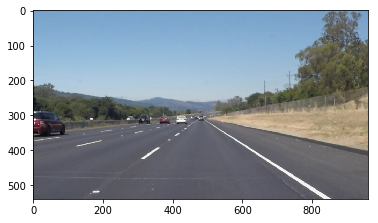

In [139]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [278]:
import math

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)    
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def drawLine(img, x, y, color=[255, 0, 0], thickness=5):
    """
    Fit a line through x[], y[] and draw it on the image 'img'.
    """
    if ((x is None) or ( y is None)):
        return
    if ((len(x) == 0) or (len(y) == 0)): 
        return
    
    param = np.polyfit(x, y, 1)
    
    m = param[0]
    b = param[1]
    
    Y_max = img.shape[0]
                         
    y1 = Y_max
    x1 = int((y1 - b)/m)
    y2 = int(Y_max/1.7)
    x2 = int((y2 - b)/m)
    cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], 4)

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    leftX = [] # Hold x-coordinates of left side of the lane
    leftY = [] # Hold y-coordinates of left side of the lane
    rightX = [] # Hold x-coordinates of right side of the lane
    rightY = [] # Hold y-coordinates of right side of the lane

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y1 - y2)/(x1 - x2)     # slope of the line segment
            
            # Leaving the extreme line segments out for a smoother and better overlap
            if ((m < -0.5) &  (m > -0.8)): 
                leftX.append(x1)
                leftX.append(x2)
                leftY.append(y1)
                leftY.append(y2)
            elif((m > 0.5) & (m < 0.8)):
                rightX.append(x1)
                rightX.append(x2)
                rightY.append(y1)
                rightY.append(y2)

    drawLine(img, leftX, leftY, color, thickness)
        
    drawLine(img, rightX, rightY, color, thickness)
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def filter_colors(image):
    """
    Filter the image to include only yellow and white pixels
    """
    # Filter white pixels
    white_threshold = 200 #130
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)


    return image2

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.



In [310]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# image ->region of interest ->  gray -> gaussian_blur -> canny -> hough_lines -> draw_lines -> weighted_img


def pipeline(image):
    
    xsize = image.shape[0]
    ysize = image.shape[1]


    max_width = image.shape[1]
    max_height = image.shape[0]

    # Region of interest
    left_bottom = (0.05*max_width, max_height)
    left_top = (0.4*max_width, max_height/1.8)
    right_top = (max_width-0.4*max_width, max_height/1.8)
    right_bottom = (max_width - 0.05*max_width, max_height)
    vertices = np.array([ [left_bottom, left_top, right_top , right_bottom] ], np.int32)

    # Gaussian Blur
    kernel_size = 15

    # Canny Edge Detector
    low_threshold = 20
    high_threshold = 100

    # Hough Transform
    rho = 1           #distance resolution in pixels of the Hough grid
    theta = 1 * np.pi/180  #angular resolution in radians of the Hough grid
    threshold = 10     #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20  #minimum number of pixels making up a line
    max_line_gap = 10

    img = filter_colors(image)

    gray = grayscale(img) 

    blur_gray = gaussian_blur(gray, kernel_size)

    masked_image = region_of_interest(blur_gray, vertices)
    

    edges = canny(masked_image, low_threshold, high_threshold)
    
    #return edges
    
    houghed = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)

    #return houghed
    # Draw lane lines on the original image
    initial_image = image.astype('uint8')
    annotated_image = weighted_img(houghed, initial_image)


    # Display the image
    return annotated_image


## Test the Pipeline

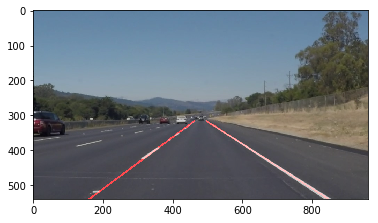

In [311]:

plt.imshow(pipeline(image))

## Test Images


Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

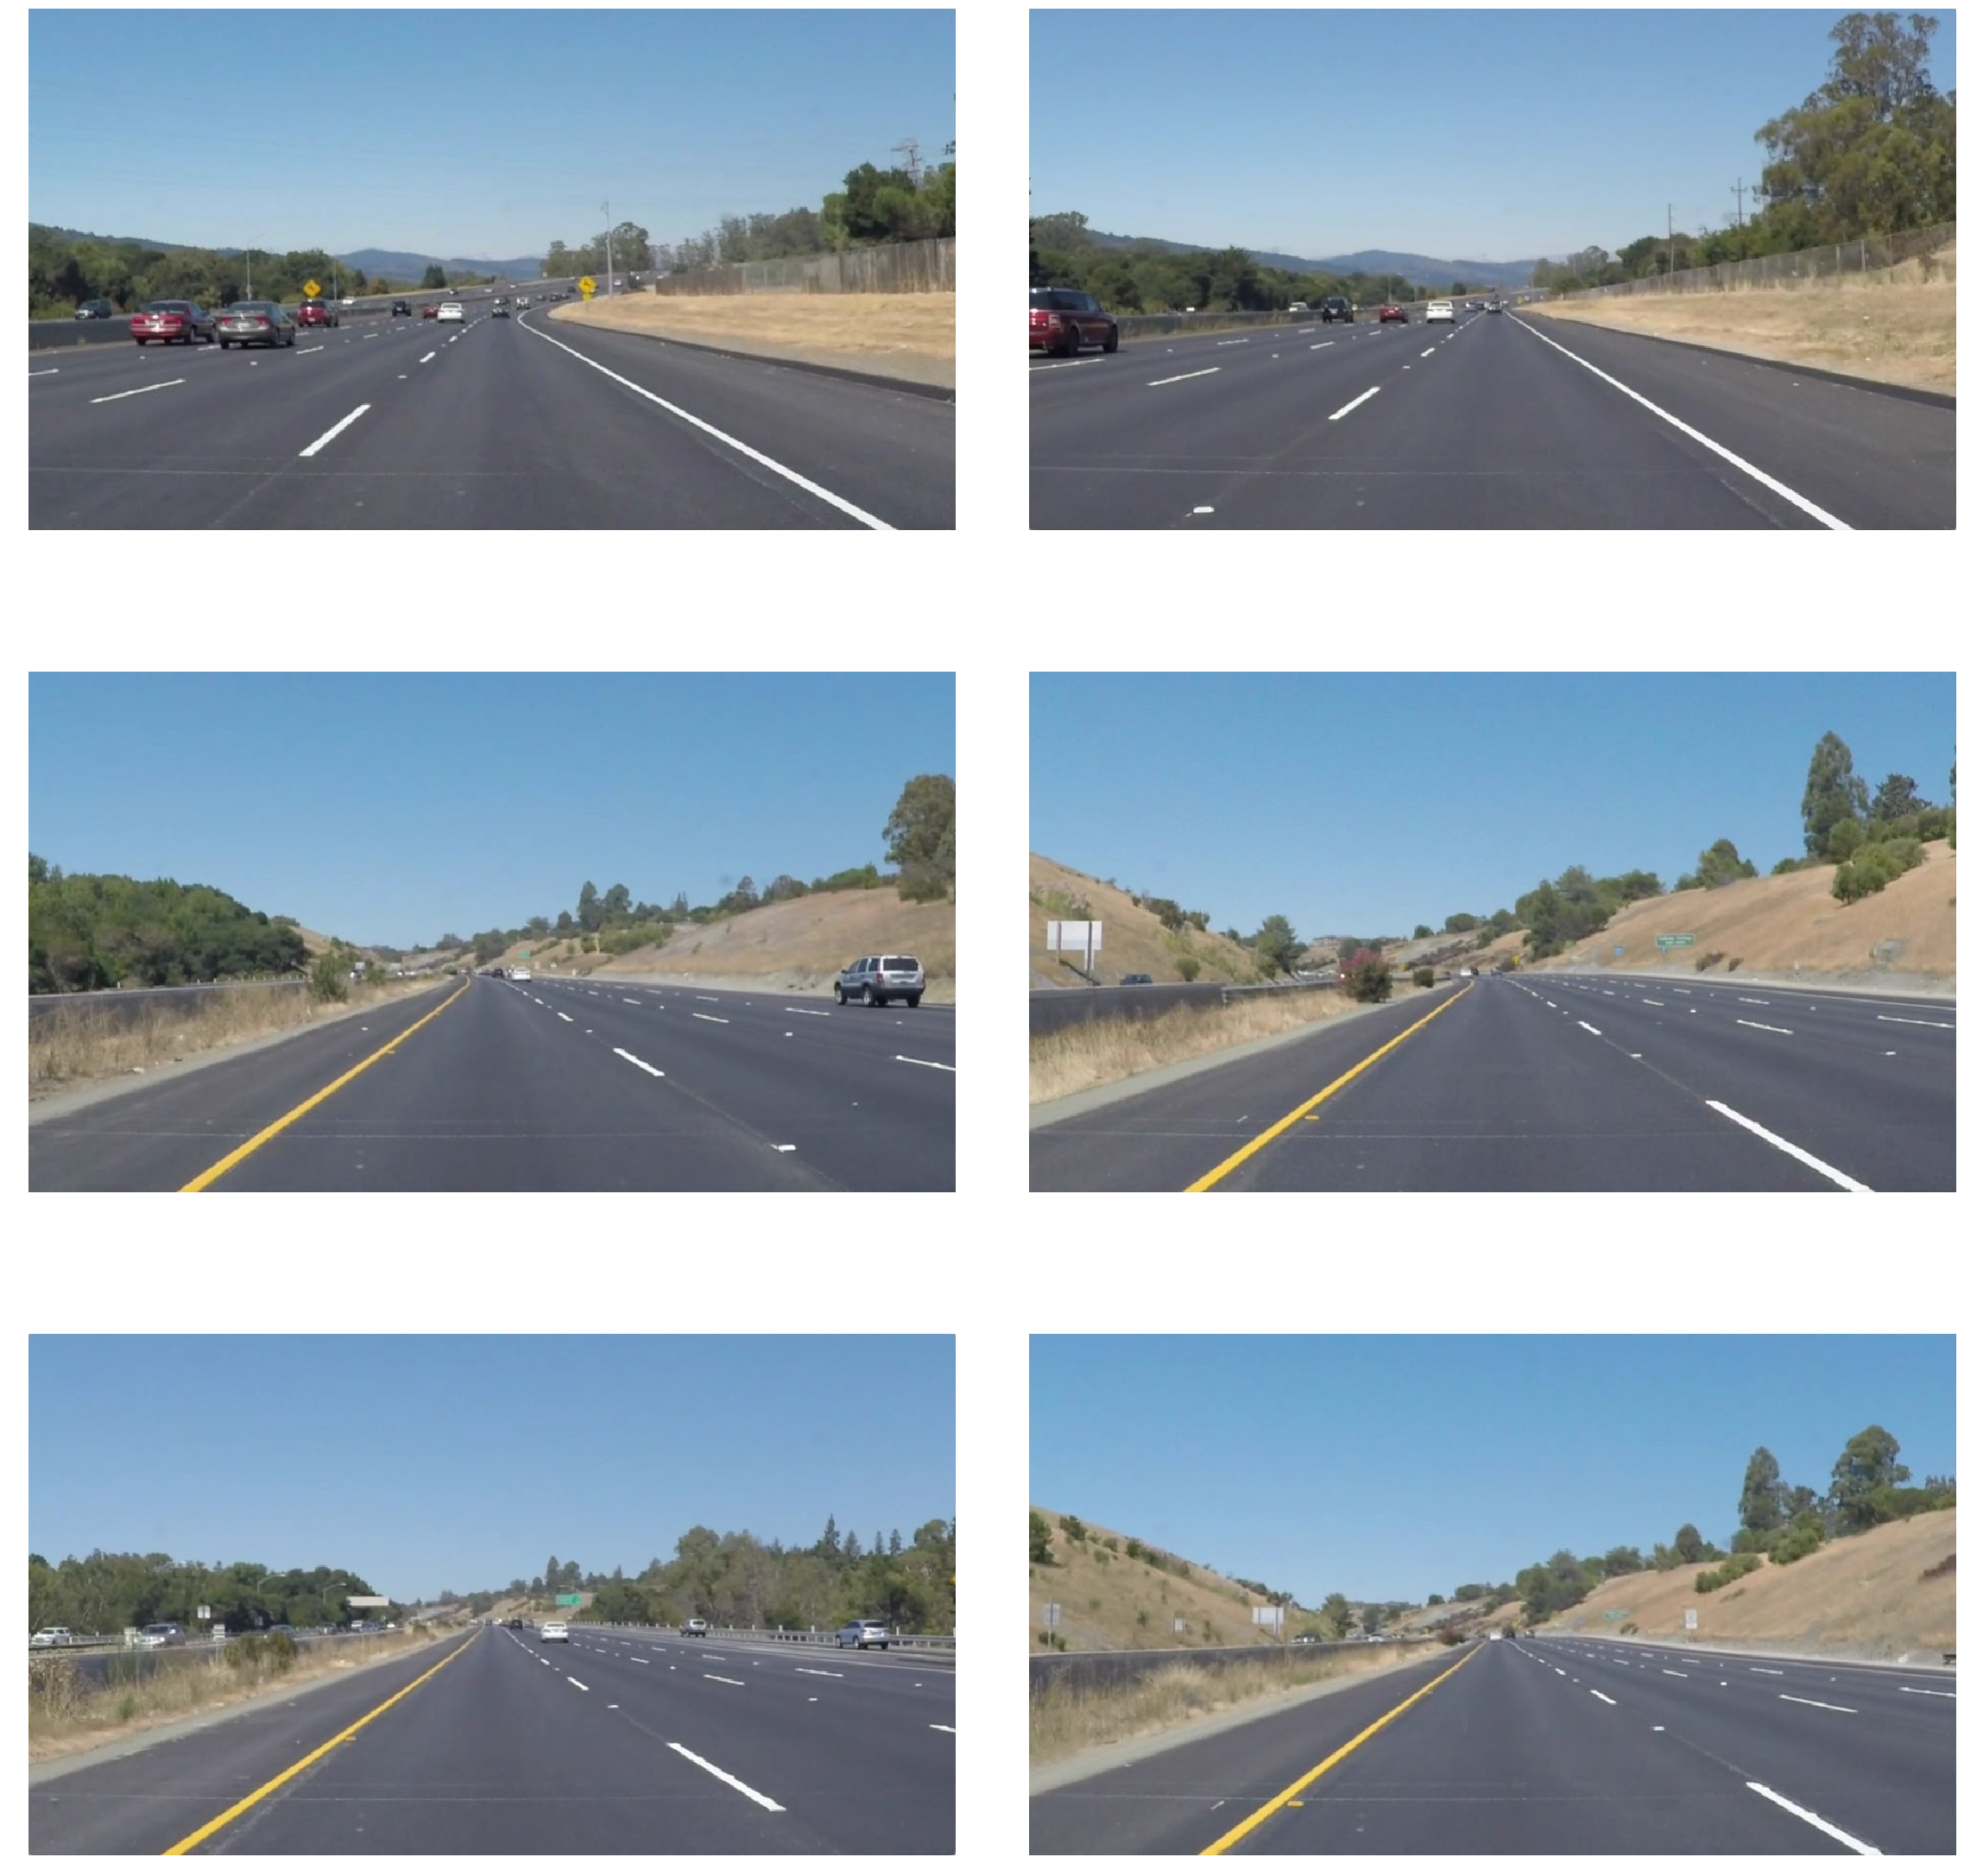

In [299]:
# Here are the test images

import os
import glob

image_name_list = glob.glob("./test_images/*.jpg")


fig = plt.figure(figsize=(40,40))
fig.subplots_adjust(wspace=0.08)
plt.clf()

for i, im in enumerate(image_name_list):
    img = mpimg.imread(im)
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(img)
    ax.axis('off')
    


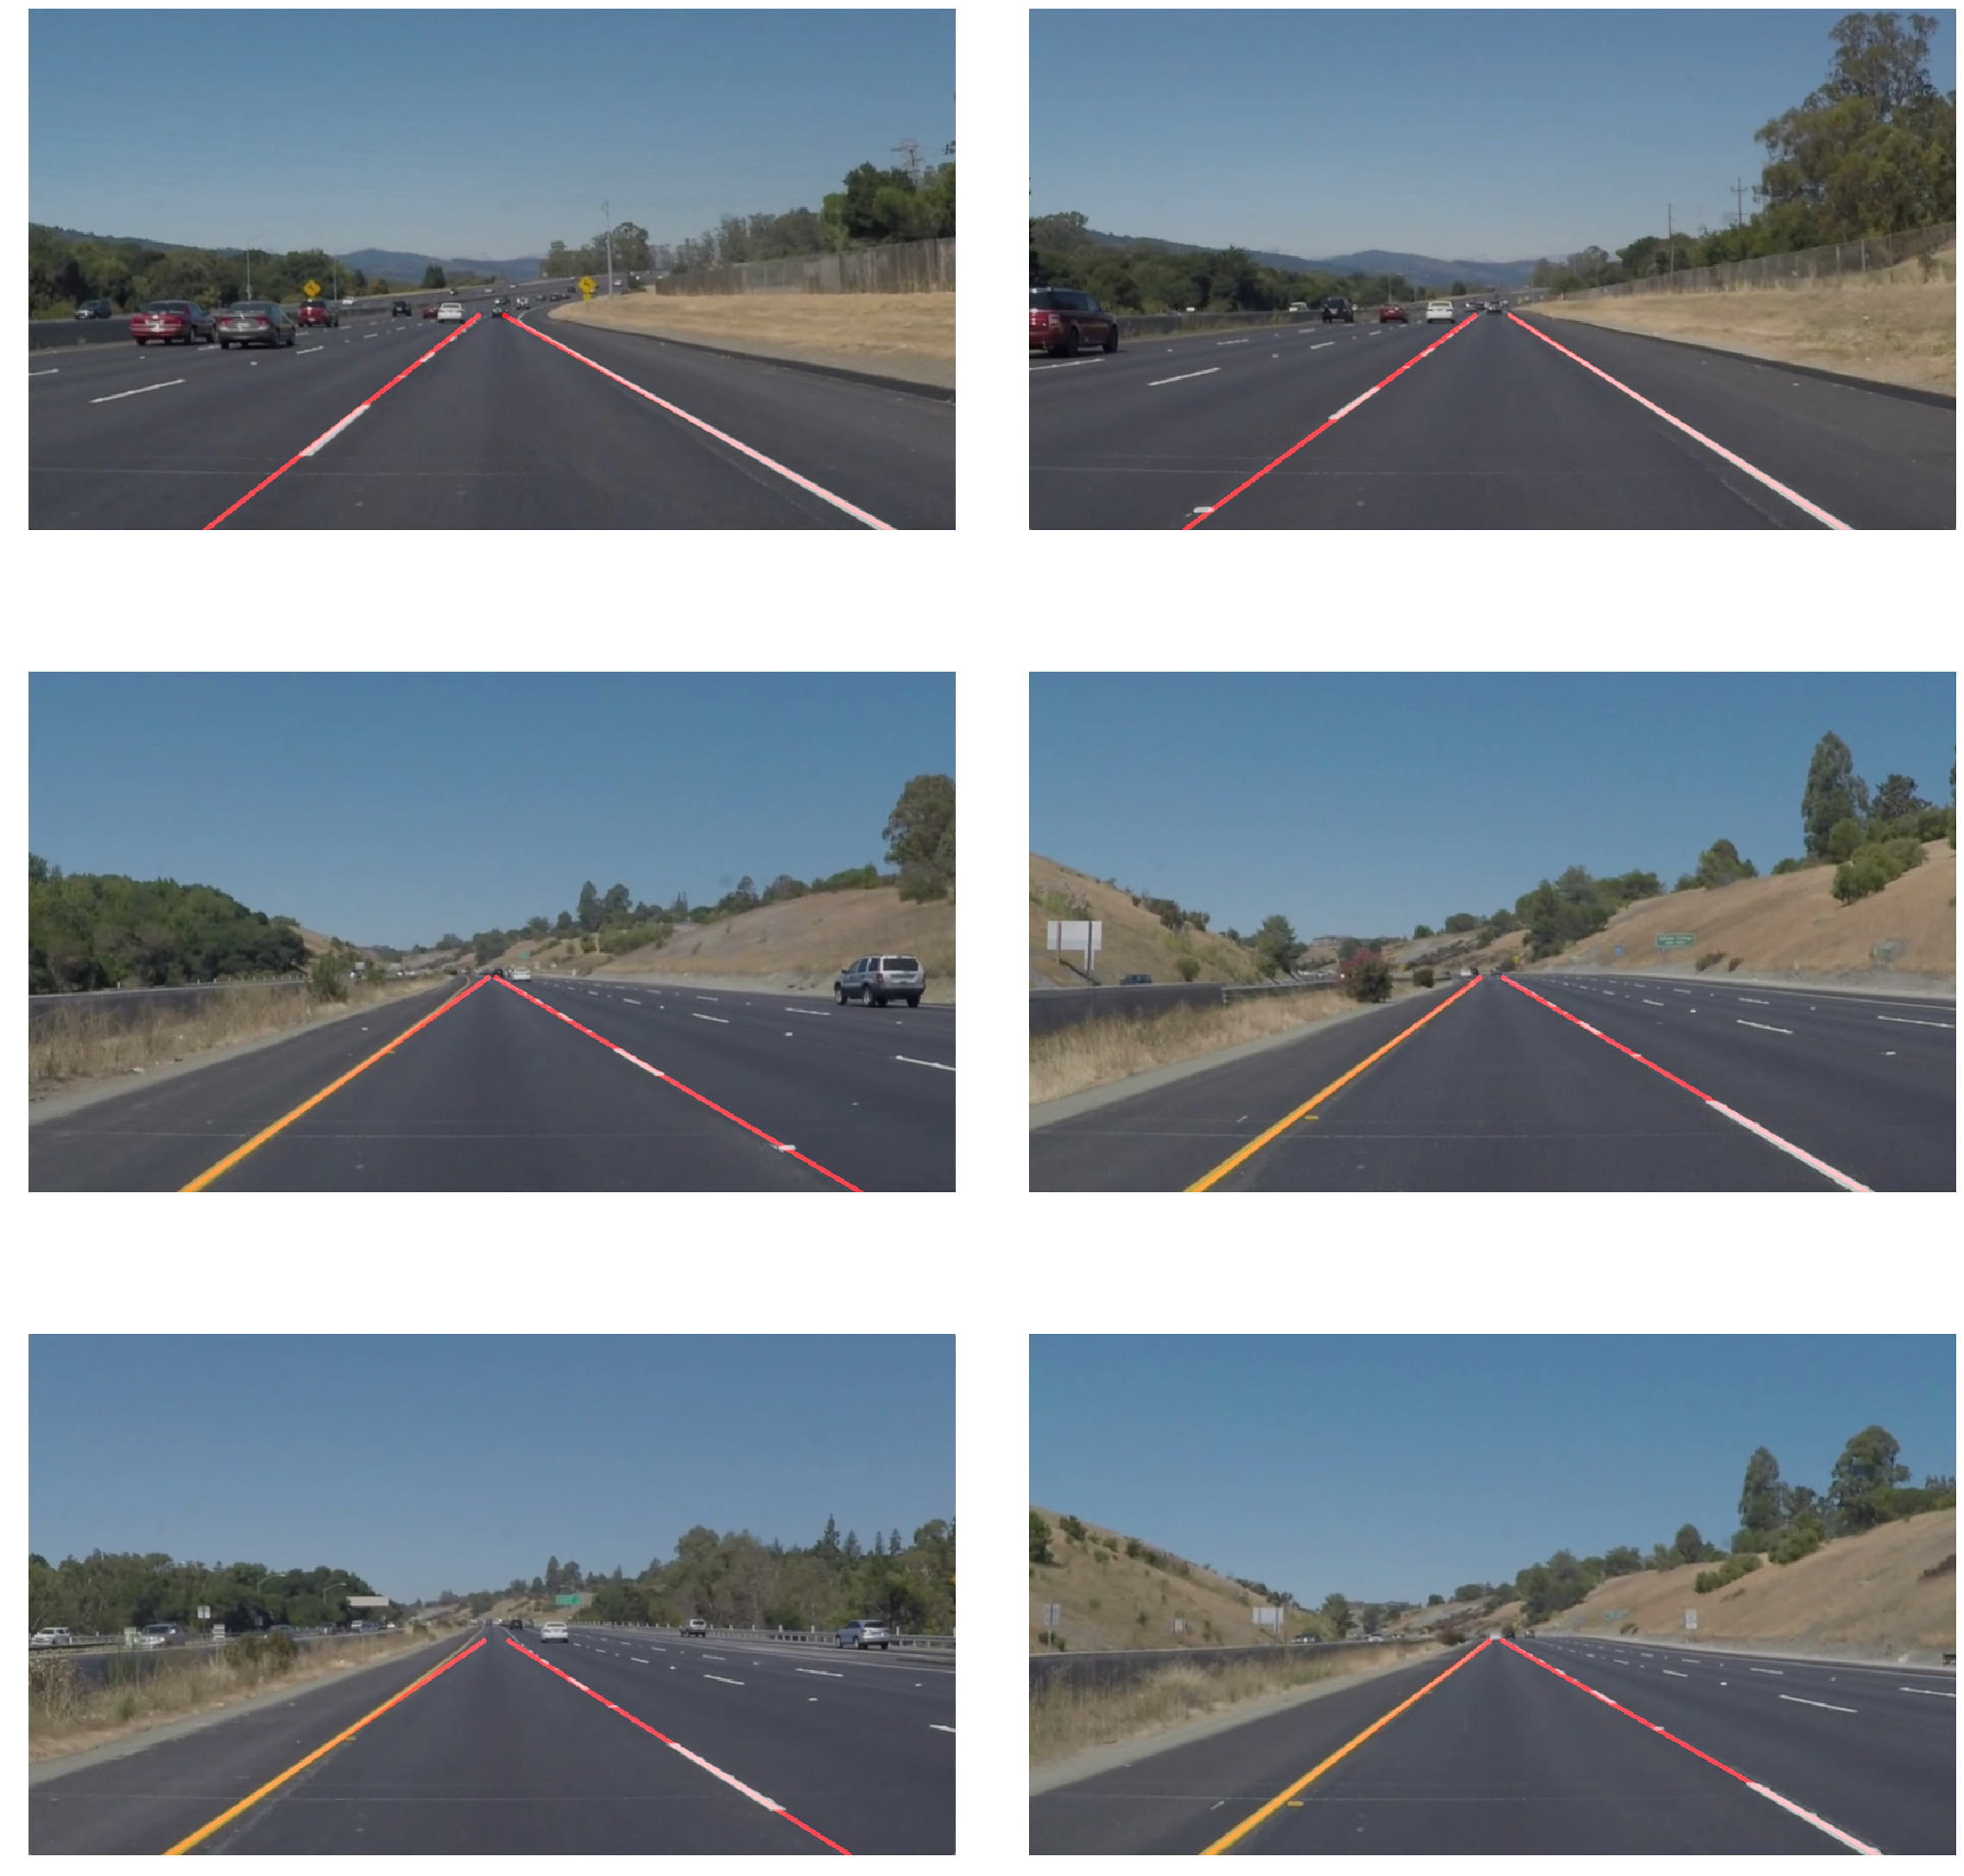

In [312]:
# Here are the test images

import os
import glob

image_name_list = glob.glob("./test_images/*.jpg")


fig = plt.figure(figsize=(40,40))
fig.subplots_adjust(wspace=0.08)
plt.clf()


for i, im in enumerate(image_name_list):
    img = mpimg.imread(im)
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(pipeline(img))
    ax.axis('off')
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [313]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [314]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return pipeline(image)



Let's try the one with the solid white lane on the right first ...

In [315]:
white_output = 'solidWhiteRight_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video solidWhiteRight_output.mp4
[MoviePy] Writing video solidWhiteRight_output.mp4


100%|█████████▉| 221/222 [00:03<00:00, 55.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight_output.mp4 

CPU times: user 4.92 s, sys: 1.38 s, total: 6.31 s
Wall time: 4.38 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [316]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [317]:
yellow_output = 'solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('./test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)



[MoviePy] >>>> Building video solidYellowLeft.mp4
[MoviePy] Writing video solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 61.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeft.mp4 

CPU times: user 14.6 s, sys: 3.87 s, total: 18.5 s
Wall time: 11.5 s


In [318]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [319]:
challenge_output = 'challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('./test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('./test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)



[MoviePy] >>>> Building video challenge.mp4
[MoviePy] Writing video challenge.mp4


 99%|█████████▉| 125/126 [00:04<00:00, 31.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge.mp4 

CPU times: user 4.76 s, sys: 1.2 s, total: 5.96 s
Wall time: 4.96 s


In [320]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))